# Importing the required libraries

In [1]:
import os
import re
import sys
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import itertools
from joblib import dump, load
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, SpatialDropout1D, Embedding

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Reading the Dataset

In [5]:
df = pd.read_csv('ResumeDataSet.csv')

# List of all Categories

In [6]:
for i in range(len(df['Category'].unique())):
    print(df['Category'].unique()[i])

Data Science
HR
Advocate
Arts
Web Designing
Mechanical Engineer
Sales
Health and fitness
Civil Engineer
Java Developer
Business Analyst
SAP Developer
Automation Testing
Electrical Engineering
Operations Manager
Python Developer
DevOps Engineer
Network Security Engineer
PMO
Database
Hadoop
ETL Developer
DotNet Developer
Blockchain
Testing


# Visualizing the length disstribution of the content in the Resumes.

<ipython-input-7-4cde9b11b65b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['length']).set_title('Resume length distribution')


Text(0.5, 1.0, 'Resume length distribution')

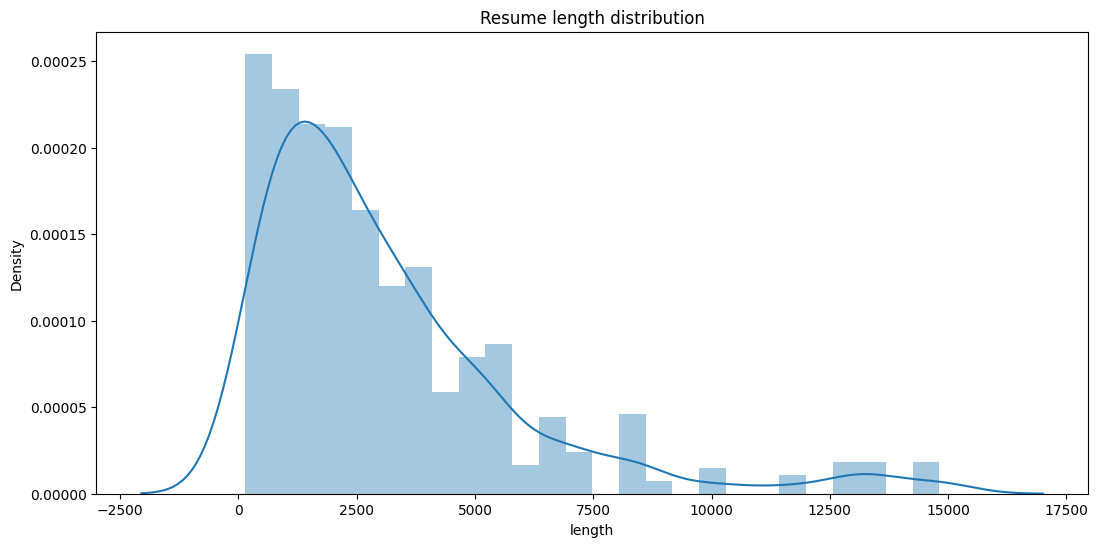

In [7]:
df['length'] = df['Resume'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(df['length']).set_title('Resume length distribution')

# Summary of Length Distribution

In [8]:
df['length'].describe()

count      962.000000
mean      3160.364865
std       2886.528521
min        142.000000
25%       1217.250000
50%       2355.000000
75%       4073.750000
max      14816.000000
Name: length, dtype: float64

# Pre-processing steps

# Checking for missing data

In [9]:
print(df.isnull().sum())

Category    0
Resume      0
length      0
dtype: int64


# Converting the data into lower case and removing words with small lengths

In [10]:
df['Resume'] = df['Resume'].apply(lambda x:x.lower())
for i in range(len(df)):
    lw=[]
    for j in df['Resume'][i].split():
        if len(j)>=3:                  
            lw.append(j)
    df['Resume'][i]=" ".join(lw)

<ipython-input-10-79d6dd5744c6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Resume'][i]=" ".join(lw)


# Removing punctuations

In [11]:
ps = list(";?.:!,")
df['Resume'] = df['Resume']

for p in ps:   
    df['Resume'] = df['Resume'].str.replace(p, '')

<ipython-input-11-34aee2d96334>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Resume'] = df['Resume'].str.replace(p, '')


# Removing '\n' and '\t', extra spaces, quoting text and progressive pronouns

In [12]:
df['Resume'] = df['Resume'].str.replace("    ", " ")
df['Resume'] = df['Resume'].str.replace('"', '')
df['Resume'] = df['Resume'].apply(lambda x: x.replace('\t', ' '))
df['Resume'] = df['Resume'].str.replace("'s", "")
df['Resume'] = df['Resume'].apply(lambda x: x.replace('\n', ' '))

# Applying Lemmatization

In [13]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [14]:
wl = WordNetLemmatizer()
nr = len(df)
lis = []
for r in range(0, nr):
    ll = []
    t = df.loc[r]['Resume']
    tw = str(t).split(" ")
    for w in tw:
        ll.append(wl.lemmatize(w, pos="v"))
    lt = " ".join(ll)
    lis.append(lt)

In [15]:
df['Resume'] = lis

# Removing Stop-words

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
sw = list(stopwords.words('english'))
for s in sw:
    rs = r"\b" + s + r"\b"
    df['Resume'] = df['Resume'].str.replace(rs, '')

<ipython-input-17-b2a2537f2ca1>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Resume'] = df['Resume'].str.replace(rs, '')


# Data Preparation for Training and Testing

In [18]:
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])
#df['Category'] = LabelEncoder().fit_transform(df['Category'])
num_classes = len(np.unique(df['Category']))

In [19]:
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Input, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.initializers import Constant

# Splitting the Data using Stratified split
X_train, X_test, y_train, y_test = train_test_split(df['Resume'], df['Category'], test_size=0.1, stratify=df['Category'], random_state=42)

# Word Embedding using GloVe
embedding_dim = 100
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

glove_file = '/content/glove.6B.100d.txt'
embeddings_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [20]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00


In [31]:
# Preparing data for CNN model
from keras_preprocessing.sequence import pad_sequences
maxlen = 3000
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

y_train_cat = to_categorical(y_train, num_classes = 25)
y_test_cat = to_categorical(y_test, num_classes = 25)

In [32]:
# Building the CNN Model
from keras.layers import GlobalMaxPooling1D
inp = Input(shape=(maxlen,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(inp)
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [33]:
# Training the Model
history = model.fit(X_train_pad, y_train_cat, batch_size=32, epochs=50, validation_data=(X_test_pad, y_test_cat))

Epoch 1/50
28/28 [==============================] - 3s 32ms/step - loss: 3.4157 - accuracy: 0.0578 - val_loss: 3.1594 - val_accuracy: 0.1546
Epoch 2/50
28/28 [==============================] - 1s 22ms/step - loss: 3.1602 - accuracy: 0.0879 - val_loss: 3.1215 - val_accuracy: 0.1959
Epoch 3/50
28/28 [==============================] - 1s 22ms/step - loss: 3.1571 - accuracy: 0.0855 - val_loss: 3.0537 - val_accuracy: 0.1959
Epoch 4/50
28/28 [==============================] - 1s 21ms/step - loss: 3.0703 - accuracy: 0.1202 - val_loss: 2.9481 - val_accuracy: 0.2268
Epoch 5/50
28/28 [==============================] - 1s 21ms/step - loss: 2.9538 - accuracy: 0.1376 - val_loss: 2.7612 - val_accuracy: 0.2371
Epoch 6/50
28/28 [==============================] - 1s 24ms/step - loss: 2.7979 - accuracy: 0.1942 - val_loss: 2.5516 - val_accuracy: 0.2887
Epoch 7/50
28/28 [==============================] - 1s 25ms/step - loss: 2.6096 - accuracy: 0.2335 - val_loss: 2.3230 - val_accuracy: 0.3814
Epoch 8/50
28

In [34]:
# Evaluating the Model
score, acc = model.evaluate(X_test_pad, y_test_cat, batch_size=32)
print('Test accuracy:', acc)

4/4 [==============================] - 0s 13ms/step - loss: 0.0480 - accuracy: 0.9897
Test accuracy: 0.9896907210350037


In [35]:
#Making predicitons for X_test (test data) 
Y_pred = model.predict(X_test_pad)
Y_pred_cat =np.argmax(Y_pred,axis=1)
Y_pred_cat

4/4 [==============================] - 0s 12ms/step


array([ 8, 23, 15, 18,  3,  0, 17,  1, 17, 12, 19, 11,  4, 18, 13, 13, 12,
       15,  7, 23, 22, 10, 20,  0, 11, 13, 24, 15,  5, 16, 14,  9, 10, 13,
       22,  6,  7,  8,  6,  8, 23, 22,  9,  4, 16, 10,  3,  7, 20, 23, 23,
       10, 20, 18, 15, 21,  5, 12, 14, 24, 16, 15, 17,  8, 23, 18, 15,  6,
       12,  7,  3, 24,  3,  4, 15, 24,  1,  8,  6, 15, 24,  1, 21, 20,  2,
       23, 22, 16, 14, 19,  2, 20, 11,  9, 19,  1,  2])

In [36]:
#We apply inverse transform to see the predicted categories
predicted_labels = le.inverse_transform(Y_pred_cat)
print(predicted_labels)

['DevOps Engineer' 'Testing' 'Java Developer' 'Operations Manager'
 'Blockchain' 'Advocate' 'Network Security Engineer' 'Arts'
 'Network Security Engineer' 'HR' 'PMO' 'Electrical Engineering'
 'Business Analyst' 'Operations Manager' 'Hadoop' 'Hadoop' 'HR'
 'Java Developer' 'Database' 'Testing' 'Sales' 'ETL Developer'
 'Python Developer' 'Advocate' 'Electrical Engineering' 'Hadoop'
 'Web Designing' 'Java Developer' 'Civil Engineer' 'Mechanical Engineer'
 'Health and fitness' 'DotNet Developer' 'ETL Developer' 'Hadoop' 'Sales'
 'Data Science' 'Database' 'DevOps Engineer' 'Data Science'
 'DevOps Engineer' 'Testing' 'Sales' 'DotNet Developer' 'Business Analyst'
 'Mechanical Engineer' 'ETL Developer' 'Blockchain' 'Database'
 'Python Developer' 'Testing' 'Testing' 'ETL Developer' 'Python Developer'
 'Operations Manager' 'Java Developer' 'SAP Developer' 'Civil Engineer'
 'HR' 'Health and fitness' 'Web Designing' 'Mechanical Engineer'
 'Java Developer' 'Network Security Engineer' 'DevOps Engin

In [37]:
#Ground Truth Labels of test data (y_test)
ground_truth_labels_test=np.argmax(y_test_cat,axis=1)
ground_truth_labels_test

array([ 8, 23, 15, 18,  3,  0, 17,  1, 17, 12, 19, 11,  4, 18, 13, 13, 12,
       15,  7, 23, 22, 10, 20,  0, 11, 13, 24, 15,  5, 16, 14,  9, 10, 13,
       22,  6,  7,  8,  6,  8, 23, 22,  9,  4, 16, 10,  3,  8, 20, 23, 23,
       10, 20, 18, 15, 21,  5, 12, 14, 24, 16, 15, 17,  8, 23, 18, 15,  6,
       12,  7,  3, 24,  3,  4, 15, 24,  1,  8,  6, 15, 24,  1, 21, 20,  2,
       23, 22, 16, 14, 19,  2, 20, 11,  9, 19,  1,  2])

In [38]:
#We apply inverse transform to the Ground Truth Labels
correct_labels = le.inverse_transform(ground_truth_labels_test)
print(correct_labels)

['DevOps Engineer' 'Testing' 'Java Developer' 'Operations Manager'
 'Blockchain' 'Advocate' 'Network Security Engineer' 'Arts'
 'Network Security Engineer' 'HR' 'PMO' 'Electrical Engineering'
 'Business Analyst' 'Operations Manager' 'Hadoop' 'Hadoop' 'HR'
 'Java Developer' 'Database' 'Testing' 'Sales' 'ETL Developer'
 'Python Developer' 'Advocate' 'Electrical Engineering' 'Hadoop'
 'Web Designing' 'Java Developer' 'Civil Engineer' 'Mechanical Engineer'
 'Health and fitness' 'DotNet Developer' 'ETL Developer' 'Hadoop' 'Sales'
 'Data Science' 'Database' 'DevOps Engineer' 'Data Science'
 'DevOps Engineer' 'Testing' 'Sales' 'DotNet Developer' 'Business Analyst'
 'Mechanical Engineer' 'ETL Developer' 'Blockchain' 'DevOps Engineer'
 'Python Developer' 'Testing' 'Testing' 'ETL Developer' 'Python Developer'
 'Operations Manager' 'Java Developer' 'SAP Developer' 'Civil Engineer'
 'HR' 'Health and fitness' 'Web Designing' 'Mechanical Engineer'
 'Java Developer' 'Network Security Engineer' 'DevOp

In [39]:
print('Accuracy:', accuracy_score(predicted_labels,correct_labels))
print('Precision:', precision_score(predicted_labels,correct_labels, average='weighted'))
print('Recall:', recall_score(predicted_labels,correct_labels, average='weighted'))
print('F1 score:', f1_score(predicted_labels,correct_labels, average='micro'))

Accuracy: 0.9896907216494846
Precision: 0.9914089347079038
Recall: 0.9896907216494846
F1 score: 0.9896907216494846
